In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import pymc3 as pm
from scipy import stats
import theano.tensor as tt

%matplotlib inline

In [2]:
data = pd.read_csv('data.csv')
data.head()

,time,a_count,b_count
0,365,13.0,15.0
1,364,24.0,19.0
2,363,8.0,70.0
3,362,24.0,49.0
4,361,7.0,7.0


In [3]:
count_data_a = np.array(data['a_count'])
count_data_b = np.array(data['b_count'])
count_data = np.concatenate((count_data_a,count_data_b))
time = np.array(data['time'])
n_count_data = len(time)

(0, 366)

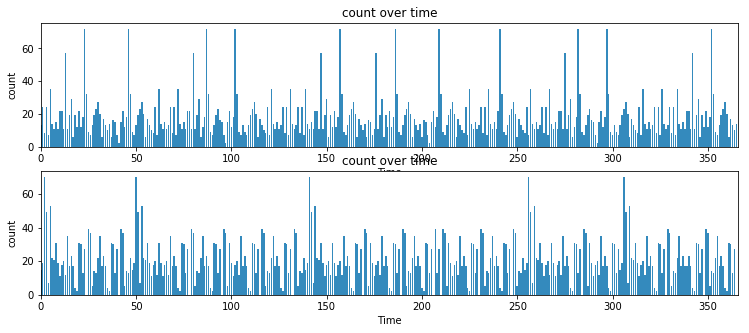

In [4]:
figsize(12.5, 5)

ax = plt.subplot(211)
plt.bar(np.arange(n_count_data), count_data_a, color="#348ABD")
plt.xlabel("Time")
plt.ylabel("count")
plt.title("count over time")
plt.xlim(0, n_count_data)

ax = plt.subplot(212)
plt.bar(np.arange(n_count_data), count_data_b, color="#348ABD")
plt.xlabel("Time")
plt.ylabel("count")
plt.title("count over time")
plt.xlim(0, n_count_data)

In [5]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    
    lambda_a = pm.Exponential("lambda_a", alpha)
    lambda_b = pm.Exponential("lambda_b", alpha)
    
    count_a = pm.Poisson("count_a", lambda_a, observed=count_data_a)
    count_b = pm.Poisson("count_b", lambda_b, observed=count_data_b)

In [ ]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)
    
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [6]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_b, lambda_a]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:08<00:00, 2520.42draws/s]


In [7]:
lambda_a_samples = trace['lambda_a']
lambda_b_samples = trace['lambda_b']
print(lambda_a_samples.mean())
print(lambda_b_samples.mean())

18.198089329711443
20.64156633321377


Text(0.5, 0, '$\\lambda_2$ value')

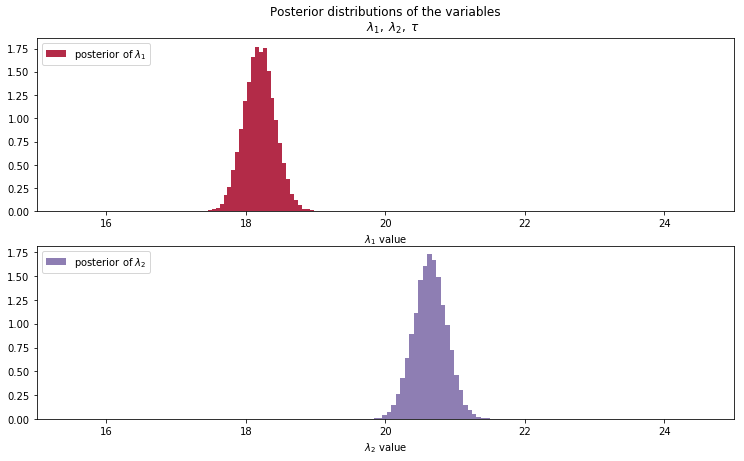

In [10]:
figsize(12.5, 7)

ax = plt.subplot(211)
ax.set_autoscaley_on(True)
plt.hist(lambda_a_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 25])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(212)
ax.set_autoscaley_on(True)
plt.hist(lambda_b_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 25])
plt.xlabel("$\lambda_2$ value")

In [15]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_a = pm.Normal('beta_a', mu=0, sd=10)
    beta_b = pm.Normal('beta_b', mu=0, sd=10)

    # define linear model and exp link function
    theta_a = (alpha + beta_a * time)
    theta_b = (alpha + beta_b * time)

    ## Define Poisson likelihood
    count_a = pm.Poisson('count_a', mu=np.exp(theta_a), observed=count_data_a)
    count_b = pm.Poisson('count_b', mu=np.exp(theta_b), observed=count_data_b)
    

In [16]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_b, beta_a, alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:16<00:00, 1281.63draws/s]
The acceptance probability does not match the target. It is 0.9446556293587384, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9430044584401759, but should be close to 0.8. Try to increase the number of tuning steps.


In [17]:
alpha_samples = trace['alpha']
beta_a_samples = trace['beta_a']
beta_b_samples = trace['beta_b']
print(alpha_samples.mean())
print(beta_a_samples.mean())
print(beta_b_samples.mean())

2.943798925072667
-0.00016751510500238322
0.0003931770184692997


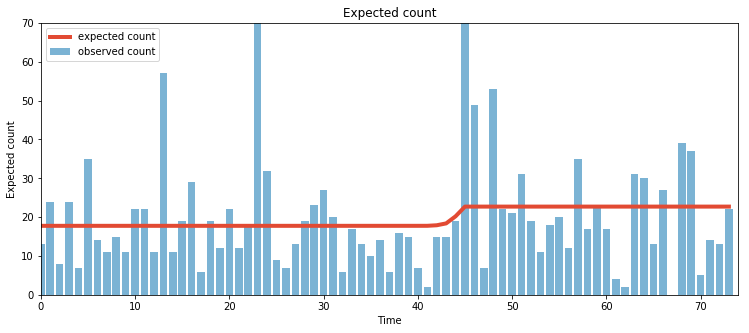

In [72]:
figsize(12.5, 5)

N = tau_samples.shape[0]
expected_count = np.zeros(n_count_data)
for t in range(0, n_count_data):
    ix = t < tau_samples
    expected_count[t] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N

plt.plot(range(n_count_data), expected_count, lw=4, color="#E24A33",
         label="expected count")
plt.xlim(0, n_count_data)
plt.xlabel("Time")
plt.ylabel("Expected count")
plt.title("Expected count")
plt.ylim(0, 70)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed count")

plt.legend(loc="upper left");

Text(0.5, 0, 'count data')

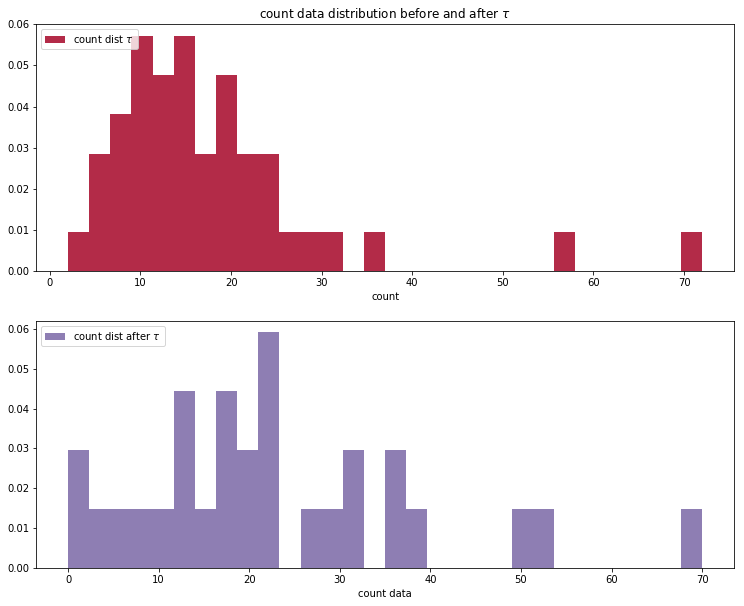

In [73]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(211)

plt.hist(count_data[:tau_mode], histtype='stepfilled', bins=30, alpha=0.85,
         label=r"count dist $\tau$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""count data distribution before and after $\tau$""")
plt.xlabel("count")

ax = plt.subplot(212)
plt.hist(count_data[tau_mode:], histtype='stepfilled', bins=30, alpha=0.85,
         label=r"count dist after $\tau$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlabel("count data")